In [1]:
from ridge_extractor import extract_ridge_from_image
from ridge_profile_fit import fit_profile
from skimage.draw import circle_perimeter
from pathlib import Path
import pandas as pd
import pickle

source_dir = Path(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_test")
# R= 0.0002
upsilon = 0.06 # from 10.1002/marc.202000360
gamma = 0.072 # from https://en.wikipedia.org/wiki/Surface_tension

initial_params = {\
    "h" : 0.001,
    "E_lookup" : {"70_S":5000,"70_H":10000,"80_S":15000,"80_H":30000},
    "upsilon" : 0.059, # from 10.1002/marc.202000360
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
    "gamma_s": 0.021, # 10.1038/ncomms5369, 10.1103/PhysRevLett.109.038001
    "theta": 100
}

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


In [ ]:
# convert numpy arrays from gwyddion to tiffs
import numpy as np
import tifffile

glb = source_dir.rglob("*f.npz")
for file in glb:
    arr: np.ndarray = np.load(file)["arr_0"]
    with open(file.with_stem(file.stem +"_img_attr").with_suffix(".txt")) as f:
        lines = f.readlines()
        pixelscale =[float(x) for x in lines[2].split(" ")[-2].strip().split(",")]
    metadata=dict(microscope="LEXT", PhysicalSizeX=pixelscale[0], PhysicalSizeY=pixelscale[1], PhysicalSizeUnit="m")
    tifffile.imwrite(Path(file).with_suffix(".ome.tif"), arr, 
                    compression="zlib", compressionargs={'level':9}, tile=(256,256), maxworkers=8,
                    metadata=metadata, shape=arr.shape, dtype=arr.dtype,
                    resolution=(1/pixelscale[0], 1/pixelscale[1]), resolutionunit=None)

70_H_1_f.ome Center: (1476,1517) Radius: 1007 Residuals: [-1109.4324849  -1108.71598495 -1107.99971509 ...  -892.15465409
  -892.84686082  -893.53934162]


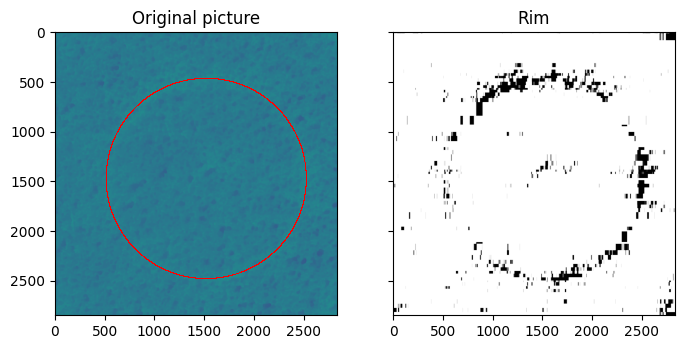

70_H_2_f.ome Center: (2409,1117) Radius: 1703 Residuals: [-912.1803593  -918.12893264 -918.79095918 ... -440.70979027 -444.70490761
 -445.50443592]


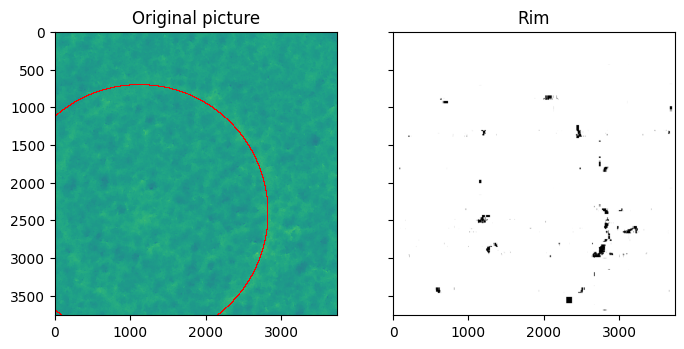

70_S_1_f.ome Center: (1256,1211) Radius: 1217 Residuals: [ -135.54417318  -134.72572983  -133.90753092 ... -1058.79270689
 -1059.50683558 -1060.22117948]


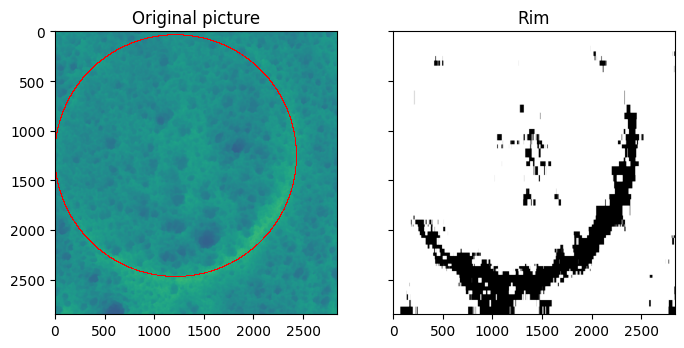

70_S_2_f.ome Center: (1796,1969) Radius: 1352 Residuals: [  -72.21917739   -70.23123411   -70.05459312 ... -1281.20611918
 -1281.87316698 -1291.23388408]


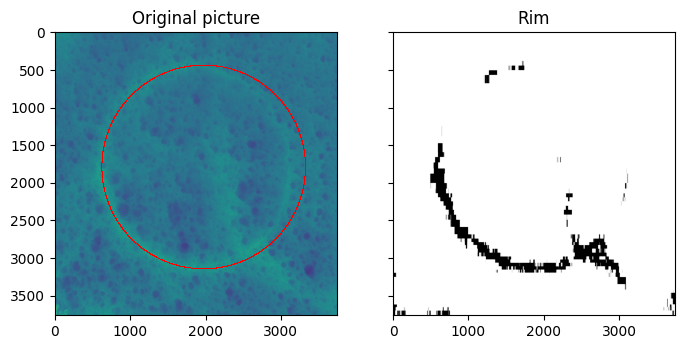

70_S_4_f.ome Center: (2373,2260) Radius: 2008 Residuals: [  32.51681221   33.34065734   34.16433974 ... -309.19294373 -309.33508252
 -309.477644  ]


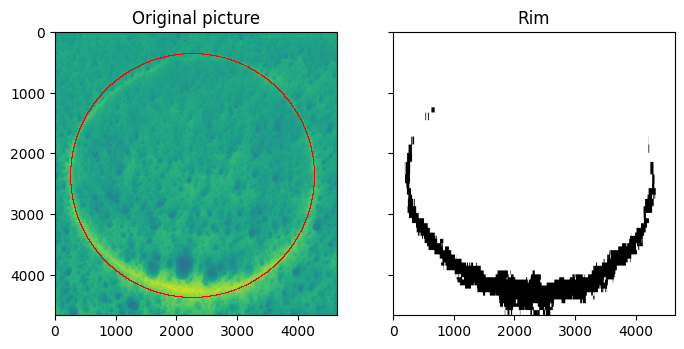

80_H_2_f.ome Center: (-27173,3448) Radius: 30262 Residuals: [2753.45419011 2753.53746105 2753.62069589 ...  -76.0799057   -76.06811667
  -76.0563606 ]


RuntimeError: Center is outside image
in function: RadialProjectionScan (D:\a\diplib\diplib\src\statistics\radial.cpp at line number 322)

In [2]:
# Extract ridge from images and store as csv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
glb = source_dir.rglob("*f.ome.tif")
for file in glb:
    try:
        ridge, img, circ_params, rim_binarized = extract_ridge_from_image(file, segmented_threshold=0.3)
        cy, cx = circle_perimeter(*circ_params)
        fig2, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4),
                                    sharex=True, sharey=True)

        ax1.set_title('Original picture')
        ax1.imshow(img)
        ax1.plot(cx,cy, "r,")

        ax2.set_title('Rim')
        ax2.imshow(rim_binarized, cmap="Greys")
        plt.show()
        df = pd.DataFrame({"x":ridge[0],"y":ridge[1]})
        df.to_csv(file.with_suffix(".rdg"), sep=";")
    except Exception as e:
        print(e)
        print(file)


In [4]:
# read csvs and fit ridge profile
files = (source_dir / "70vs80_first").rglob("*2_f.rdg")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(source_dir / "70vs80_first/fit_data.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

files = (source_dir / "70vs80_second").rglob("*2_f.rdg")

fit_params = dict()
for f in files:
    fit_params[str(f)] = fit_profile(f, **initial_params)

with open(source_dir / "70vs80_second/fit_data.p","wb") as f:
    pickle.dump(fit_params, f, protocol=pickle.HIGHEST_PROTOCOL)

70_H_2 - 0.0
Shanahan:	R2 -341.747
Limat:		R2 -1.304
Style R>>h:	R2 -35.448
Style:		R2 -0.635

70_S_2 - 0.0
Shanahan:	R2 0.191
Limat:		R2 -0.047
Style R>>h:	R2 0.061
Style:		R2 -0.134

80_H_2 - 0.0
Shanahan:	R2 -503.527
Limat:		R2 -26.341
Style R>>h:	R2 -197.459
Style:		R2 -12.192

80_S_2 - 0.0
Shanahan:	R2 -5.231
Limat:		R2 0.231
Style R>>h:	R2 -1.114
Style:		R2 -0.336

70_H_2 - 0.0
Shanahan:	R2 -137.821
Limat:		R2 -0.148
Style R>>h:	R2 -19.027
Style:		R2 -0.088

70_S_2 - 0.0
Shanahan:	R2 0.122
Limat:		R2 -0.305
Style R>>h:	R2 0.071
Style:		R2 -0.355

80_H_2 - 0.0
Shanahan:	R2 -10.456
Limat:		R2 -0.166
Style R>>h:	R2 -3.180
Style:		R2 0.063

80_S_2 - 0.0
Shanahan:	R2 0.540
Limat:		R2 -0.084
Style R>>h:	R2 0.053
Style:		R2 -0.397



In [ ]:
import pickle
from IPython.display import display, Markdown

with open(r"D:\Messungen\Profilometry\Lasermikroskop\Wetting_Ridge\70vs80_first\fit_data.p","rb") as f:
    fit_params: dict[str, dict[str,RidgeFit]] = pickle.load(f)

sha_md = ["| Sample | d | 𝜃 | E | R2 |","| --- | --- | --- | --- | --- |"]
lim_md = ["| Sample | 𝛾ₛ | 𝜃 | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ld_md = ["| Sample | 𝛶ₛ | h | E |R2 |","| --- | --- | --- | --- | --- |"]
st_ex_md = ["| Sample | 𝛶ₛ | h | E | R2 |","| --- | --- | --- | --- | --- |"]

for fit_name, ridgefit in fit_params.items():
    fit = ridgefit["shanahan"]
    popt, perr = fit.popt, fit.perr
    sha_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[1]:1.4e}±{perr[1]:1.2e}|{popt[0]:.1f}±{perr[0]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["limat"]
    popt, perr = fit.popt, fit.perr
    lim_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[1]:.1f}±{perr[1]:.1f}°|{popt[2]:.1f}±{perr[2]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style_ld"]
    popt, perr = fit.popt, fit.perr
    st_ld_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")
    fit = ridgefit["style"]
    popt, perr = fit.popt, fit.perr
    st_ex_md.append(f"|{fit.iron_content}_{fit.shear_mod}_{fit.volume}|{popt[0]:.4f}±{perr[0]:.4f} N/m|{popt[2]*1000:.3f}±{perr[2]*1000:.3f} mm|{popt[1]:.1f}±{perr[1]:.1f} Pa|{fit.r2}")

sha_md = "\n".join(sha_md)
lim_md = "\n".join(lim_md)
st_ld_md = "\n".join(st_ld_md)
st_ex_md = "\n".join(st_ex_md)

display(Markdown("## Shanahan\n\n" + sha_md + "\n## Limat\n\n" + lim_md + "\n## Style\n### R>>h\n" + st_ld_md + "\n### exact\n" + st_ex_md))

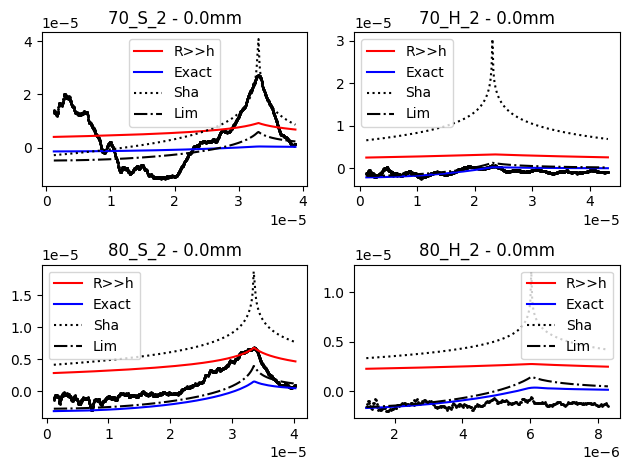

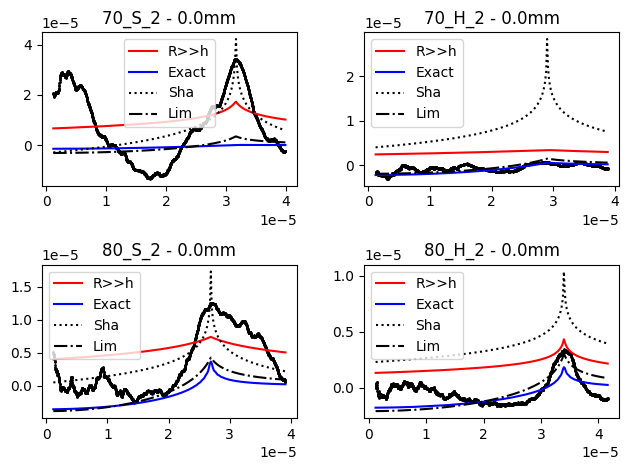

In [6]:
import pickle
import numpy as np
from data_types import RidgeFit
from ridge_models import style_exact, style_ld_ts, shanahan, limat_symmetric

with open(source_dir / "70vs80_first/fit_data.p","rb") as f:
    fit_params: dict[str, dict[str, RidgeFit]] = pickle.load(f)

from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,2)
i=0
for fit_name, fit in fit_params.items():
    
    # drop, popt_ld_ts, popt_hemi, pcov_ld_ts, pcov_hemi, x_ax, defl = fit
    # vol, R, G, Fe = drop
    i = 0 if fit["style"].shear_mod == "S" else 1
    j = 0 if fit["style"].iron_content == "70" else 1
    plt.sca(ax[j,i])
    fit_x = np.linspace(fit["style"].x_values.min(), fit["style"].x_values.max(), 250)

    plt.plot(fit["style"].x_values, fit["style"].y_values,"k.", markersize=2)
    rf = fit["style_ld"]
    plt.plot(fit_x, style_ld_ts(fit_x, rf.gamma, rf.radius, *rf.popt), "r-", label='R>>h')
    rf = fit["style"]
    plt.plot(fit_x, style_exact(fit_x, rf.gamma, rf.radius, *rf.popt), "b-", label="Exact")
    rf = fit["shanahan"]
    plt.plot(fit_x, shanahan(fit_x, rf.gamma, rf.radius, *rf.popt), "k:", label="Sha")
    rf = fit["limat"]
    plt.plot(fit_x, limat_symmetric(fit_x, rf.gamma, rf.radius, *rf.popt), "k-.", label="Lim")
    r = fit["style"].radius*1000
    plt.title(f"{fit["style"].iron_content}_{fit["style"].shear_mod}_{fit["style"].volume} - {r:.1f}mm")
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()

with open(source_dir / "70vs80_second/fit_data.p","rb") as f:
    fit_params: dict[str, dict[str, RidgeFit]] = pickle.load(f)

fig, ax = plt.subplots(2,2)
i=0
for fit_name, fit in fit_params.items():
    
    # drop, popt_ld_ts, popt_hemi, pcov_ld_ts, pcov_hemi, x_ax, defl = fit
    # vol, R, G, Fe = drop
    i = 0 if fit["style"].shear_mod == "S" else 1
    j = 0 if fit["style"].iron_content == "70" else 1
    plt.sca(ax[j,i])
    fit_x = np.linspace(fit["style"].x_values.min(), fit["style"].x_values.max(), 250)

    plt.plot(fit["style"].x_values, fit["style"].y_values,"k.", markersize=2)
    rf = fit["style_ld"]
    plt.plot(fit_x, style_ld_ts(fit_x, rf.gamma, rf.radius, *rf.popt), "r-", label='R>>h')
    rf = fit["style"]
    plt.plot(fit_x, style_exact(fit_x, rf.gamma, rf.radius, *rf.popt), "b-", label="Exact")
    rf = fit["shanahan"]
    plt.plot(fit_x, shanahan(fit_x, rf.gamma, rf.radius, *rf.popt), "k:", label="Sha")
    rf = fit["limat"]
    plt.plot(fit_x, limat_symmetric(fit_x, rf.gamma, rf.radius, *rf.popt), "k-.", label="Lim")
    r = fit["style"].radius*1000
    plt.title(f"{fit["style"].iron_content}_{fit["style"].shear_mod}_{fit["style"].volume} - {r:.1f}mm")
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()